In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import json

from rich import print

from python.analysis import Master, BeamParticleSelection, PFOSelection, Plots, shower_merging, vector, Tags, cross_section, EventSelection

import awkward as ak
import numpy as np

shower_merging.SetPlotStyle(extend_colors = True, dpi = 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
config = "work/2023/cex_analysis_2GeV_config.json"
if not config:
    mc = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type = Master.Ntuple_Type.PDSP)
    data = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01.root", nTuple_type = Master.Ntuple_Type.PDSP)

    beam_quality_fits = {
        "mc" : "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03_fit_values.json",
        "data" : "work/2023/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01_fit_values.json"
    }
else:
    args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
    mc = Master.Data(args.mc_file, nTuple_type = Master.Ntuple_Type.PDSP, nEvents = -1)
    data = Master.Data(args.data_file, nTuple_type = Master.Ntuple_Type.PDSP, nEvents = -1)
    beam_quality_fits = {"mc" : args.mc_beam_quality_fit, "data" : args.data_beam_quality_fit}

samples = {"mc" : mc, "data": data}

def FilterSamples(samples : dict, masks : dict, PFO : bool = False):
    for s in samples:
        if PFO:
            samples[s].Filter([masks[s]])
        else:
            samples[s].Filter([masks[s]], [masks[s]])

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1176: RuntimeWarning: divide by zero encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1177: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((data_err/h_data)**2 + (mc_error/h_mc)**2)


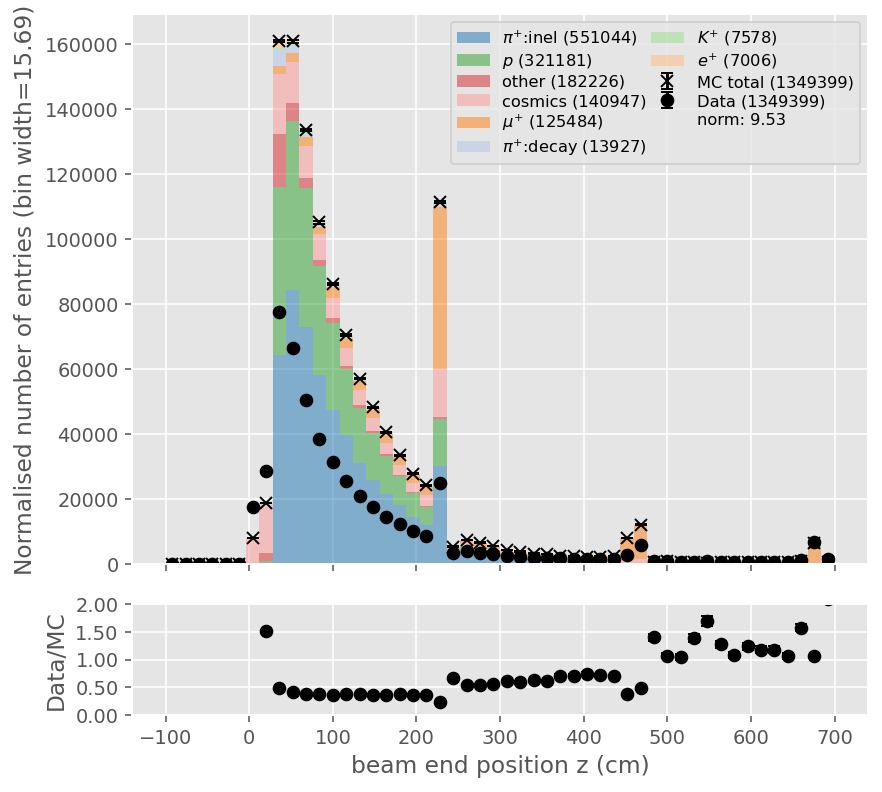

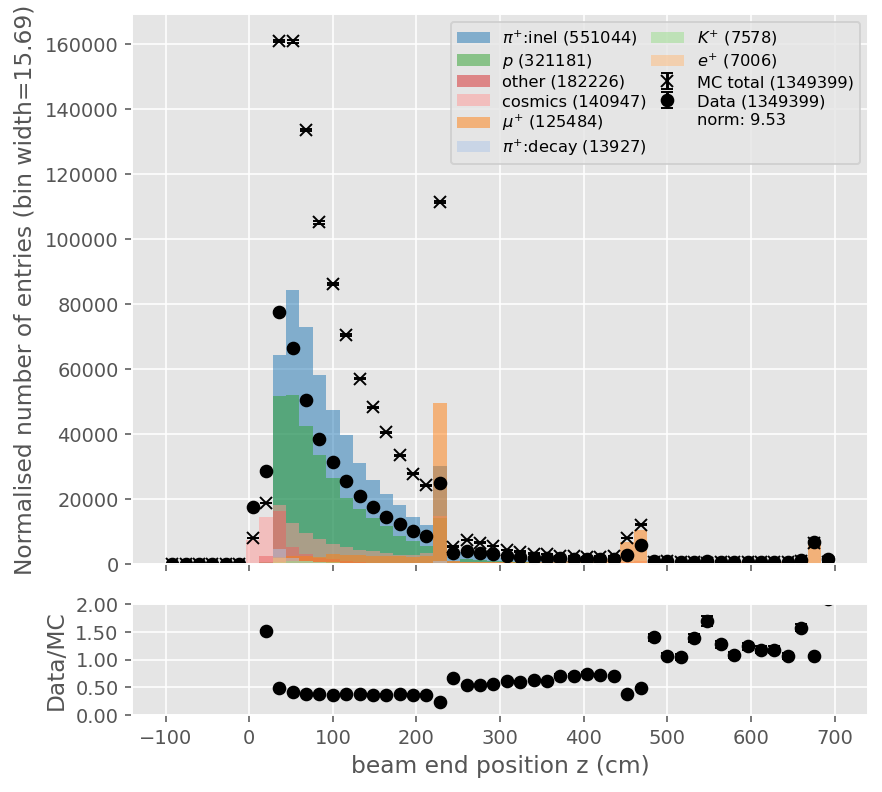

In [3]:
Plots.PlotTagged(mc.recoParticles.beam_endPos.z, Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_endPos.z, x_range = [-100, 700], norm = True, bins = 50, x_label = "beam end position z (cm)", stacked = True, alpha = 0.5)
Plots.PlotTagged(mc.recoParticles.beam_endPos.z, Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_endPos.z, x_range = [-100, 700], norm = True, bins = 50, x_label = "beam end position z (cm)", stacked = False, alpha = 0.5)
# Plots.PlotTagged(mc.trueParticles.endPos.z[:, 0], Tags.GenerateTrueBeamParticleTags(mc), x_range = [-100, 700], norm = True, bins = 50, x_label = "true beam end position z (cm)")

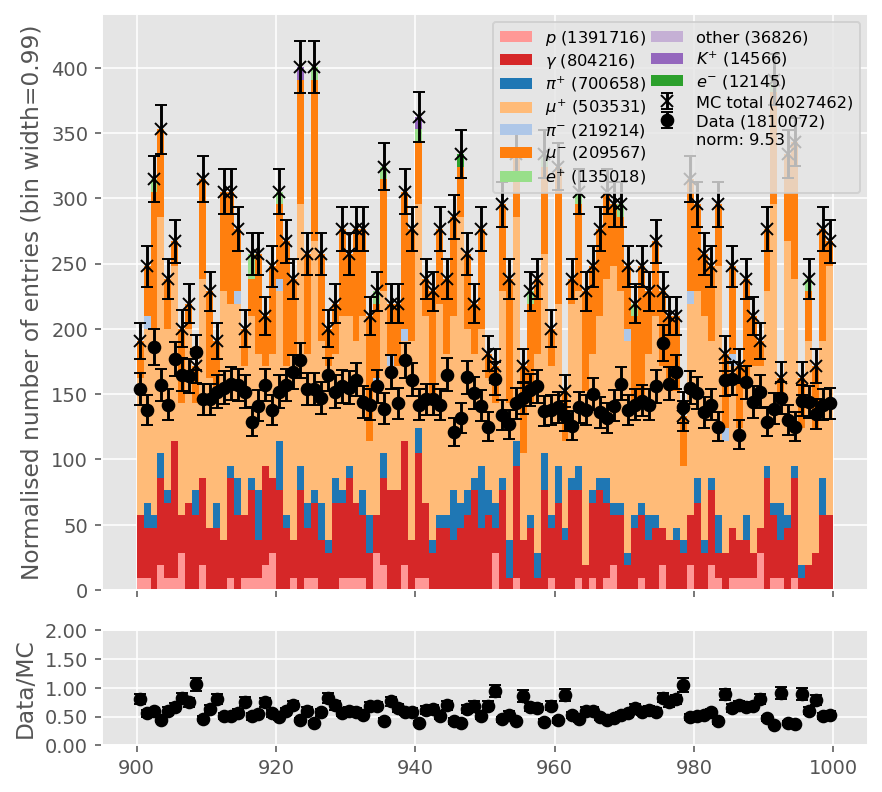

In [4]:
event_normalisation = ak.count(data.eventNum) / ak.count(mc.eventNum)
pfo_normalisation = ak.count(data.recoParticles.number) / ak.count(mc.recoParticles.number)
Plots.PlotTagged(mc.recoParticles.shower_energy, Tags.GenerateTrueParticleTags(mc), data2 = data.recoParticles.shower_energy, y_scale = "linear", norm = event_normalisation, x_range = [900, 1000])

In [4]:
Tags.GenerateTrueParticleTagsPi0Shower(samples["mc"])

{'$\\gamma$': Tag(name='$\\gamma$', name_simple='$\\gamma$', colour='C0', mask=<Array [[], [], [False, ... False], [False]] type='141548 * var * bool'>, number=0),
 '$\\gamma$:beam $\\pi^0$': Tag(name='$\\gamma$:beam $\\pi^0$', name_simple='$\\gamma$:beam $\\pi^0$', colour='C1', mask=<Array [[], [], [False, ... False], [False]] type='141548 * var * bool'>, number=1),
 '$\\gamma$:other $\\pi^0$': Tag(name='$\\gamma$:other $\\pi^0$', name_simple='$\\gamma$:other $\\pi^0$', colour='C2', mask=<Array [[], [], [False, ... False], [False]] type='141548 * var * bool'>, number=2),
 '$\\pi^{+}$': Tag(name='$\\pi^{+}$', name_simple='$\\pi^{+}$', colour='C3', mask=<Array [[], [], [False, ... True], [True]] type='141548 * var * bool'>, number=3),
 '$\\pi^{-}$': Tag(name='$\\pi^{-}$', name_simple='$\\pi^{-}$', colour='C4', mask=<Array [[], [], [False, ... False], [False]] type='141548 * var * bool'>, number=4),
 '$\\mu^{-}$': Tag(name='$\\mu^{-}$', name_simple='$\\mu^{-}$', colour='C5', mask=<Array 

# Beam Particle Selection

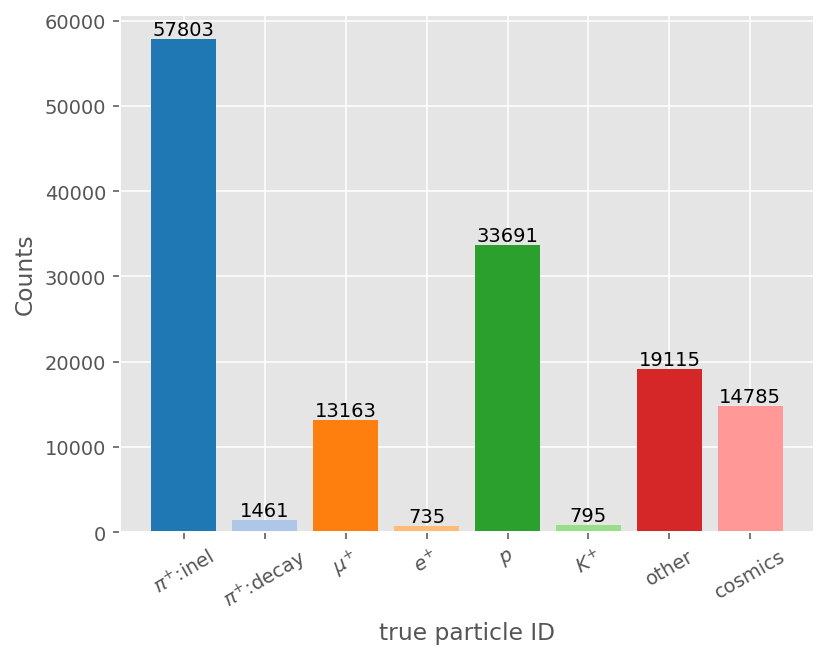

In [36]:
masks = {
    "mc" : BeamParticleSelection.PiBeamSelection(samples["mc"]),
    "data" : BeamParticleSelection.PiBeamSelection(samples["data"], use_beam_inst = True)
}

Plots.PlotTags(Tags.GenerateTrueBeamParticleTags(samples["mc"]), "true particle ID")

FilterSamples(samples, masks)

In [ ]:
masks = {s : BeamParticleSelection.CaloSizeCut(samples[s]) for s in samples}
FilterSamples(samples, masks)

In [ ]:
masks = {s : BeamParticleSelection.PandoraTagCut(samples[s]) for s in samples}

if data is None:
    Plots.PlotBar(samples["mc"])
else:
    Plots.PlotBarComparision(samples["mc"].recoParticles.beam_pandora_tag, samples["data"].recoParticles.beam_pandora_tag, label_1 = "MC", label_2 = "Data", xlabel = "pandora beam tag", fraction = True, barlabel = True)

FilterSamples(samples, masks)

In [ ]:
def norm(x, mu, sigma):
    return (x - mu) / sigma

# Beam quality cuts
for i in ["x", "y", "z"]:
    Plots.PlotTagged(mc.recoParticles.beam_startPos_SCE[i], Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_startPos_SCE[i], x_label = i + "(cm)", y_scale = "log", norm = True)

#* dxy cut
dxy = {s : (norm(samples[s].recoParticles.beam_startPos_SCE.x, beam_quality_fits[s]["mu_x"], beam_quality_fits[s]["sigma_x"])**2 + norm(samples[s].recoParticles.beam_startPos_SCE.y, beam_quality_fits[s]["mu_y"], beam_quality_fits[s]["sigma_y"])**2)**0.5 for s in samples}
masks = {s : dxy[s] < 3 for s in samples}

Plots.PlotTagged(dxy["mc"], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(dxy["data"]), bins = 50, x_label = "$dxy$ (cm)", y_scale = "log", x_range = [0, 5], norm = True)
Plots.DrawCutPosition(3, arrow_length = 1, face = "left")

[print(f"dxy cut: {BeamParticleSelection.CountMask(masks[s])}") for s in masks]
FilterSamples(samples, masks)


In [ ]:
deltas_mc = {}
deltas_data = {}
for i in ["x", "y", "z"]:
    deltas_mc[i] = norm(samples["mc"].recoParticles.beam_startPos_SCE[i], beam_quality_fits["mc"][f"mu_{i}"], beam_quality_fits["mc"][f"sigma_{i}"])
    deltas_data[i] = norm(samples["data"].recoParticles.beam_startPos_SCE[i], beam_quality_fits["data"][f"mu_{i}"], beam_quality_fits["data"][f"sigma_{i}"])
    Plots.PlotTagged(deltas_mc[i], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(deltas_data[i]), bins = 50, x_range = [-10, 10], y_scale = "log", x_label = f"$(" + i + "- \mu_{"+ i + "} )/ \sigma_{" + i + "}$", ncols = 3, norm = True)
    Plots.DrawCutPosition(-3, arrow_length = 1, face = "right")
    Plots.DrawCutPosition(3, arrow_length = 1, face = "left")


masks = {
    "mc" : (deltas_mc["z"] > -3) & (deltas_mc["z"] < 3),
    "data" : (deltas_data["z"] > -3) & (deltas_data["z"] < 3)
}

FilterSamples(samples, masks)

In [ ]:
beam_dir = {s : vector.normalize(vector.sub(samples[s].recoParticles.beam_endPos_SCE, samples[s].recoParticles.beam_startPos_SCE)) for s in samples}

beam_dir_mu = {s : vector.normalize(vector.vector(beam_quality_fits[s]["mu_dir_x"], beam_quality_fits[s]["mu_dir_y"], beam_quality_fits[s]["mu_dir_z"])) for s in beam_quality_fits}

beam_costh = {s : vector.dot(beam_dir[s], beam_dir_mu[s]) for s in beam_dir_mu}

Plots.PlotTagged(beam_costh["mc"], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(beam_costh["data"]), x_label = "$\cos(\\theta)$", y_scale = "log", bins = 50, x_range = [0.9, 1], norm = True)
Plots.DrawCutPosition(0.95, arrow_length = 0.02)

masks = {s : beam_costh[s] > 0.95 for s in samples}
FilterSamples(samples, masks)

In [ ]:
Plots.PlotTagged(samples["mc"].recoParticles.beam_endPos_SCE.z, Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.beam_endPos.z, x_label = "Beam end position z (cm)", norm = args.norm, bins = 50, y_scale = "log", ncols = 1)
Plots.DrawCutPosition(220, face = "left", arrow_length = 50)

masks = {s : BeamParticleSelection.APA3Cut(samples[s]) for s in samples}

FilterSamples(samples, masks)

In [ ]:
# michel score cut

scores = {}
for s in samples:
    score = ak.where(samples[s].recoParticles.beam_nHits != 0, samples[s].recoParticles.beam_michelScore / samples[s].recoParticles.beam_nHits, -999)
    masks[s] = BeamParticleSelection.MichelScoreCut(samples[s])
    scores[s] = score

Plots.PlotTagged(scores["mc"], Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = np.array(scores["data"]), x_range = (0, 1), y_scale = "log", bins = 50, x_label = "michel score", ncols = 3, norm = args.norm)
Plots.DrawCutPosition(0.55, face = "left")

FilterSamples(samples, masks)

In [ ]:
median = {s : PFOSelection.Median(samples[s].recoParticles.beam_dEdX) for s in samples}

Plots.PlotTagged(median["mc"], Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = median["data"], y_scale = "log", x_range = [0, 10], x_label = "median $dE/dX$ (MeV/cm)", norm = True)
Plots.DrawCutPosition(2.4, face = "left", arrow_length = 2)

masks = {s : BeamParticleSelection.MedianDEdXCut(samples[s]) for s in samples}
FilterSamples(samples, masks)

In [ ]:
a = {"mc" : "mc_arguments", "data" : "data_arguments"}
masks = {s : BeamParticleSelection.BeamScraperCut(samples[s], args.beam_selection[a[s]]["BeamScraperCut"]["KE_range"], args.beam_selection[a[s]]["BeamScraperCut"]["fits"], args.beam_selection[a[s]]["BeamScraperCut"]["pdg_hyp"], args.beam_selection[a[s]]["BeamScraperCut"]["cut"]) for s in samples}

nx = {s : norm(samples[s].recoParticles.beam_inst_pos.x, ak.mean(samples[s].recoParticles.beam_inst_pos.x), ak.std(samples[s].recoParticles.beam_inst_pos.x)) for s in samples}
ny = {s : norm(samples[s].recoParticles.beam_inst_pos.y, ak.mean(samples[s].recoParticles.beam_inst_pos.y), ak.std(samples[s].recoParticles.beam_inst_pos.y)) for s in samples}

r = {s : (nx[s]**2 + ny[s]**2)**0.5 for s in samples}

Plots.PlotTagged(r["mc"], data2 = r["data"], tags = Tags.GenerateTrueBeamParticleTags(samples["mc"]), norm = True)
Plots.DrawCutPosition(args.beam_selection[a[s]]["BeamScraperCut"]["cut"], arrow_length = 1, face = "left", arrow_loc = 0.6)

FilterSamples(samples, masks)

In [ ]:
samples["mc"].cutTable.get_table()

In [ ]:
samples["data"].cutTable.get_table()

# Quick Beam Selection

In [4]:
for s in args.beam_selection["selections"]:
    mc_mask = args.beam_selection["selections"][s](samples["mc"], **args.beam_selection["mc_arguments"][s])
    samples["mc"].Filter([mc_mask], [mc_mask])
    data_mask = args.beam_selection["selections"][s](samples["data"], **args.beam_selection["data_arguments"][s])
    samples["data"].Filter([data_mask], [data_mask])

print(samples["mc"].cutTable.get_table(pfos = False, percent_remain = False, relative_percent = False, ave_per_event = False))
print(samples["data"].cutTable.get_table(pfos = False, percent_remain = False, relative_percent = False, ave_per_event = False))

masks = {s : PFOSelection.GoodShowerSelection(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

print(samples["mc"].cutTable.get_table(events = False, percent_remain = False, relative_percent = False, ave_per_event = False))
print(samples["data"].cutTable.get_table(events = False, percent_remain = False, relative_percent = False, ave_per_event = False))

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


Name  Remaining events
0   Initial data            141548
1              -            102443
2              -             91248
3              -             87403
4              -             68150
5              -             62438
6              -             59985
7              -             48795
8              -             48575
9              -             46726
10             -             30016

Name  Remaining events
0   Initial data           1349399
1              -            285238
2              -            248398
3              -            232423
4              -            181810
5              -            174422
6              -            162761
7              -            124320
8              -            123883
9              -            117662
10             -             74352

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos_SCE.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_endPos_SCE.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/

Name  Remaining PFOs
0   Initial data          422469
1              -          339292
2              -          330673
3              -          317779
4              -          242725
5              -          222475
6              -          215150
7              -          182476
8              -          181732
9              -          176298
10             -          114333
11             -          101704

Name  Remaining PFOs
0   Initial data         1810072
1              -          936036
2              -          897614
3              -          839940
4              -          638385
5              -          612478
6              -          575570
7              -          484694
8              -          483234
9              -          464163
10             -          298326
11             -          263254

In [19]:
args.piplus_selection["selections"]

photon_mask = EventSelection.SelectionTools.CombineSelections(samples["mc"], list(args.piplus_selection["selections"].values()), 1, list(args.piplus_selection["mc_arguments"].values()))

In [26]:
pi0_args = args.pi0_selection
for s in pi0_args["mc_arguments"]:
    pi0_args["mc_arguments"][s]["photon_mask"] = photon_mask
print(pi0_args)

{
    'selections': {
        'NPhotonCandidateSelection': <function NPhotonCandidateSelection at 0x7f9bde58fbe0>,
        'Pi0MassSelection': <function Pi0MassSelection at 0x7f9bde58fd00>,
        'Pi0OpeningAngleSelection': <function Pi0OpeningAngleSelection at 0x7f9bde58fc70>
    },
    'mc_arguments': {
        'NPhotonCandidateSelection': {
            'cut': 2,
            'photon_mask': <Array [[False], ... False, False, False]] type='30016 * var * bool'>
        },
        'Pi0MassSelection': {
            'cut': [50, 250],
            'correction': <staticmethod(<function EnergyCorrection.ResponseCorrection at 0x7f9bde1b1510>)>,
            'correction_params': {'p0': 0.15514869965129238, 'p1': 22.848092032157204, 'p2': -1.0621258640813378},
            'photon_mask': <Array [[False], ... False, False, False]] type='30016 * var * bool'>
        },
        'Pi0OpeningAngleSelection': {
            'cut': [10, 80],
            'photon_mask': <Array [[False], ... False, False, False]] type='30016 * var * bool'>
        }
    },
    'data_arguments': {
        'NPhotonCandidateSelection': {'cut': 2},
        'Pi0MassSelection': {
            'cut': [50, 250],
            'correction': <staticmethod(<function EnergyCorrection.ResponseCorrection at 0x7f9bde1b1510>)>,
            'correction_params': {'p0': 0.15514869965129238, 'p1': 22.848092032157204, 'p2': -1.0621258640813378}
        },
        'Pi0OpeningAngleSelection': {'cut': [10, 80]}
    }
}

In [27]:
pi0_mask = EventSelection.SelectionTools.CombineSelections(samples["mc"], list(args.pi0_selection["selections"].values()), 1, list(args.pi0_selection["mc_arguments"].values()))


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(


[50, 250]


# $\pi^{+}$ Particle Selection

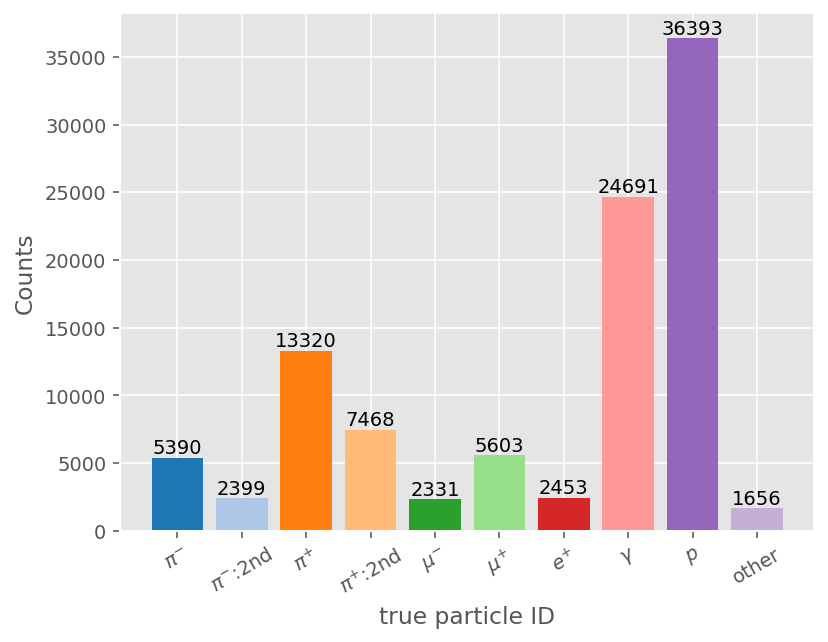

In [39]:
Plots.PlotTags(Tags.GenerateTrueParticleTagsPiPlus(samples["mc"]), "true particle ID")

In [ ]:
# only for my ntuples
masks = {s : PFOSelection.BeamDaughterCut(samples[s]) for s in samples}
Plots.PlotTagged(samples["mc"].recoParticles.track_score, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.track_score, y_scale = "log", x_label = "track score", norm = True)


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos_SCE.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_endPos_SCE.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/

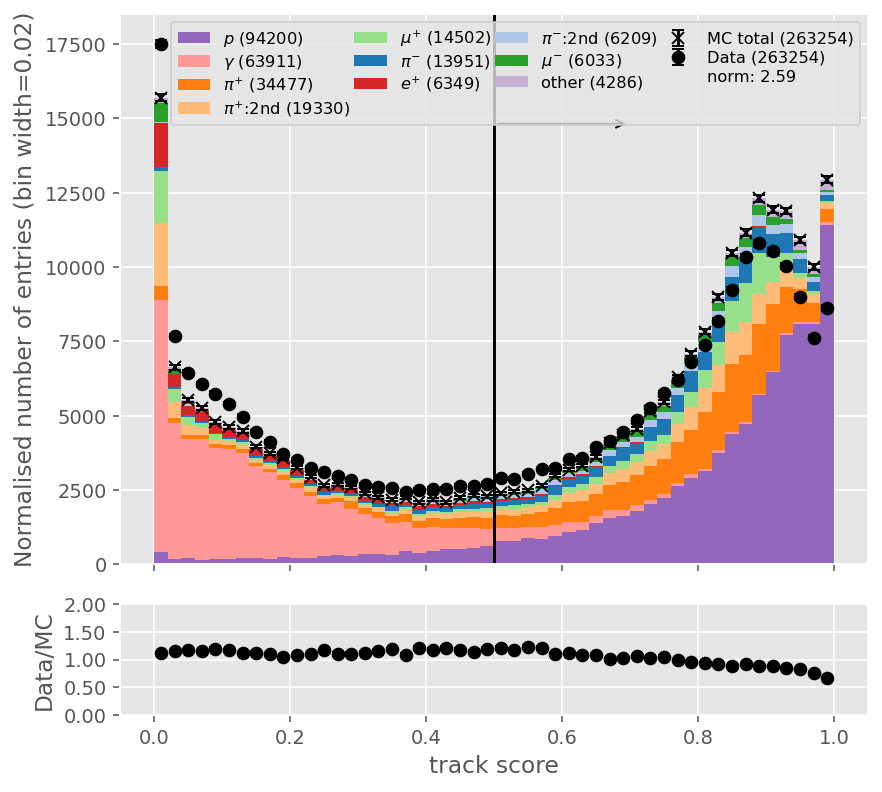

In [40]:
Plots.PlotTagged(samples["mc"].recoParticles.track_score, Tags.GenerateTrueParticleTagsPiPlus(samples["mc"]), data2 = samples["data"].recoParticles.track_score, y_scale = "linear", bins = 50, ncols = 4, x_label = "track score", norm = True)
Plots.DrawCutPosition(0.5, face = "right")

masks = {s : PFOSelection.TrackScoreCut(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

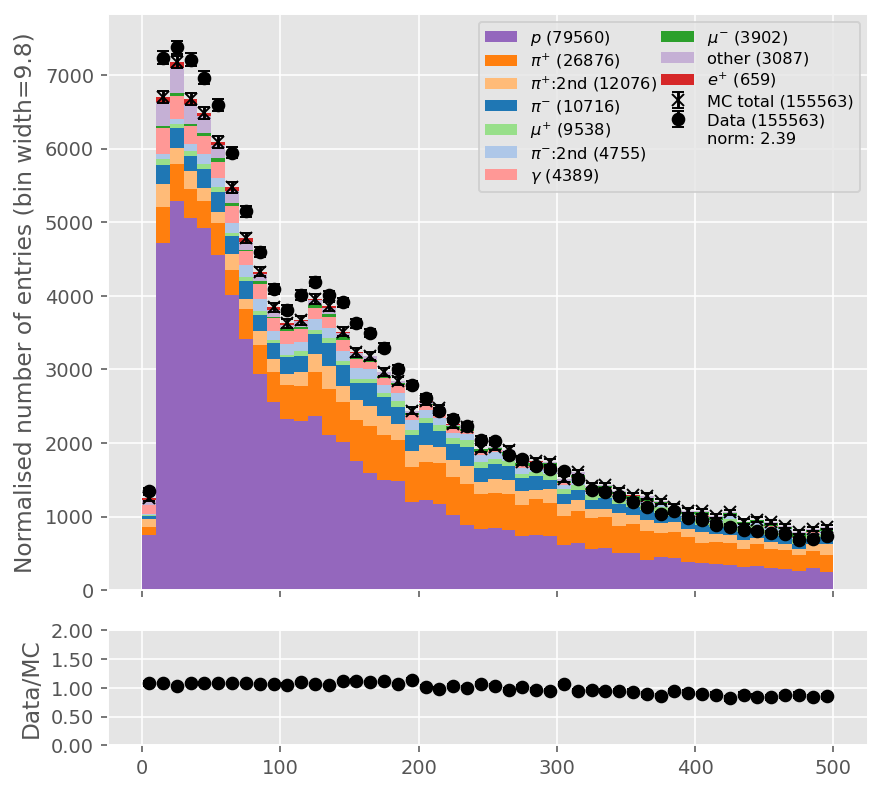

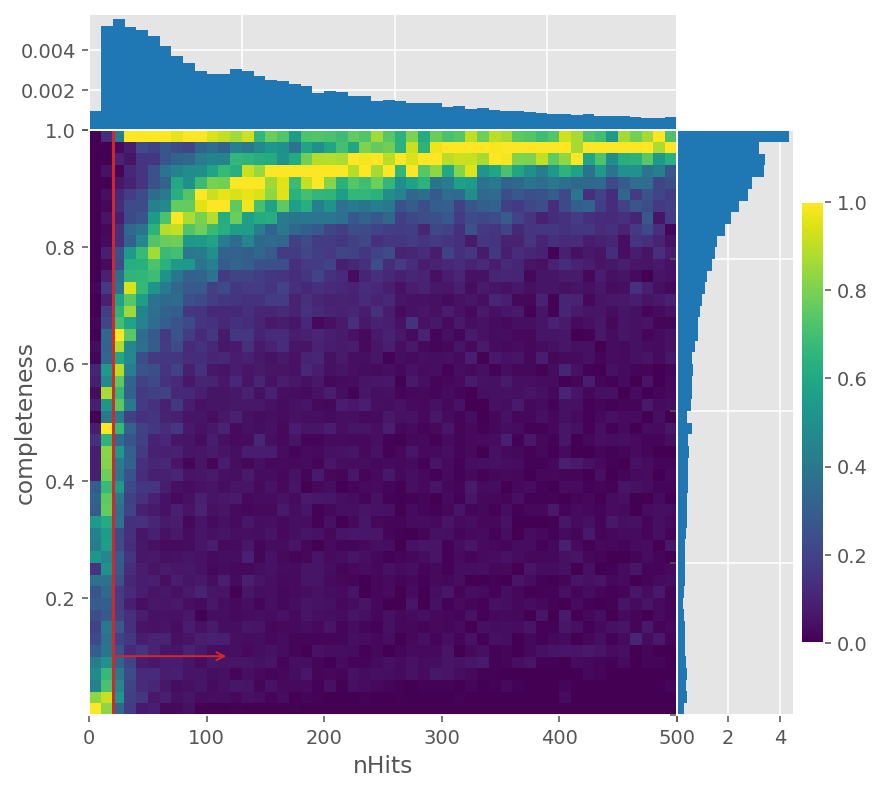

In [41]:
Plots.PlotTagged(samples["mc"].recoParticles.n_hits, Tags.GenerateTrueParticleTagsPiPlus(samples["mc"]), data2 = samples["data"].recoParticles.n_hits, bins = 50, ncols = 2, x_range = [0, 500], norm = True)
# Plots.PlotHist2D(ak.ravel(samples["mc"].trueParticlesBT.completeness), ak.ravel(samples["mc"].recoParticles.n_hits), xlabel = "completeness", ylabel = "n_hits", y_range = [0, 500], bins = 50)

Plots.PlotHist2DImshowMarginal(ak.ravel(samples["mc"].recoParticles.n_hits), ak.ravel(samples["mc"].trueParticlesBT.completeness), ylabel = "completeness", xlabel = "n_hits", x_range = [0, 500], bins = 50, norm = "column", c_scale = "linear")
Plots.DrawCutPosition(20, arrow_length = 100, arrow_loc = 0.1, color = "C6")

masks = {s : PFOSelection.NHitsCut(samples[s], 20) for s in samples}
FilterSamples(samples, masks, True)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1235: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1236: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((data_err/h_data)**2 + (mc_error/h_mc)**2)


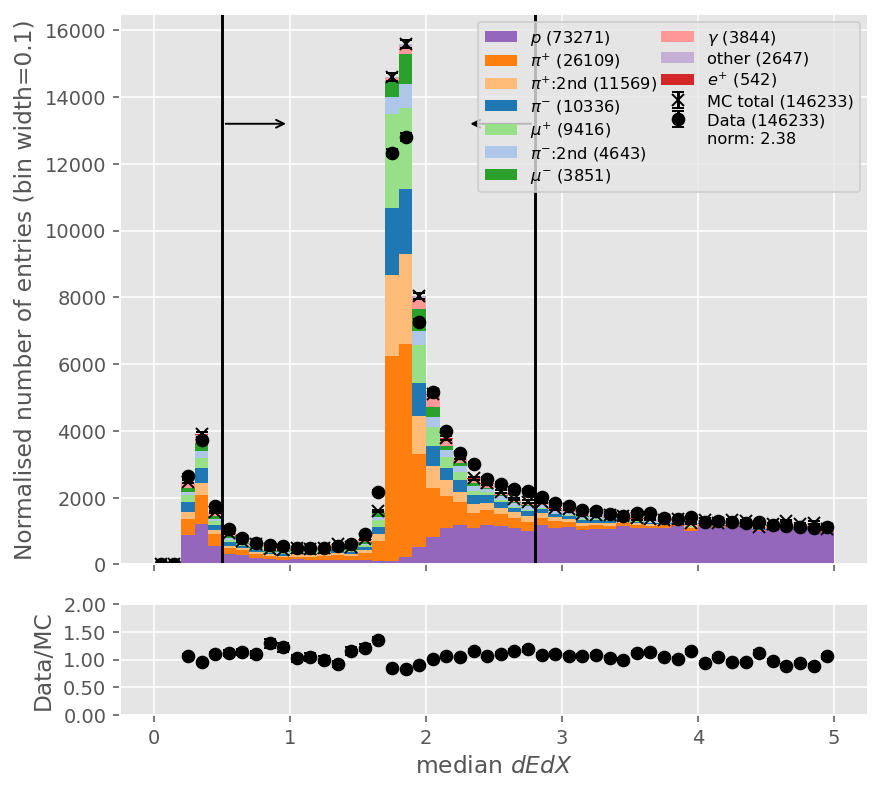

In [42]:
median_dEdX = {s : PFOSelection.Median(samples[s].recoParticles.track_dEdX) for s in samples}
Plots.PlotTagged(median_dEdX["mc"], Tags.GenerateTrueParticleTagsPiPlus(samples["mc"]), data2 = median_dEdX["data"], ncols = 2, x_range = [0, 5], x_label = "median $dEdX$", bins = 50, norm = True)

Plots.DrawCutPosition(0.5, arrow_length = 0.5, face = "right")
Plots.DrawCutPosition(2.8, arrow_length = 0.5, face = "left")

masks = {s : PFOSelection.PiPlusSelection(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

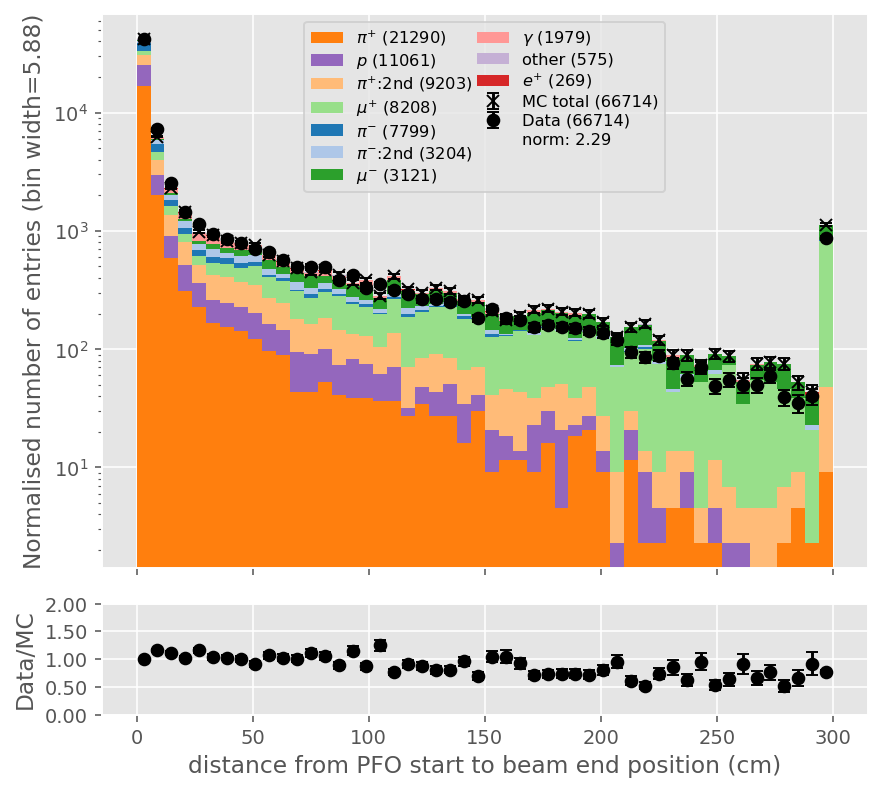

In [43]:
dist = {s : vector.dist(samples[s].recoParticles.shower_start_pos, samples[s].recoParticles.beam_endPos) for s in samples}
Plots.PlotTagged(dist["mc"], Tags.GenerateTrueParticleTagsPiPlus(samples["mc"]), data2 = dist["data"], bins = 50, x_label = "distance from PFO start to beam end position (cm)", ncols = 2, loc = "upper center", norm = True, stacked = "descending", truncate = True, y_scale = "log", x_range = [0, 300])

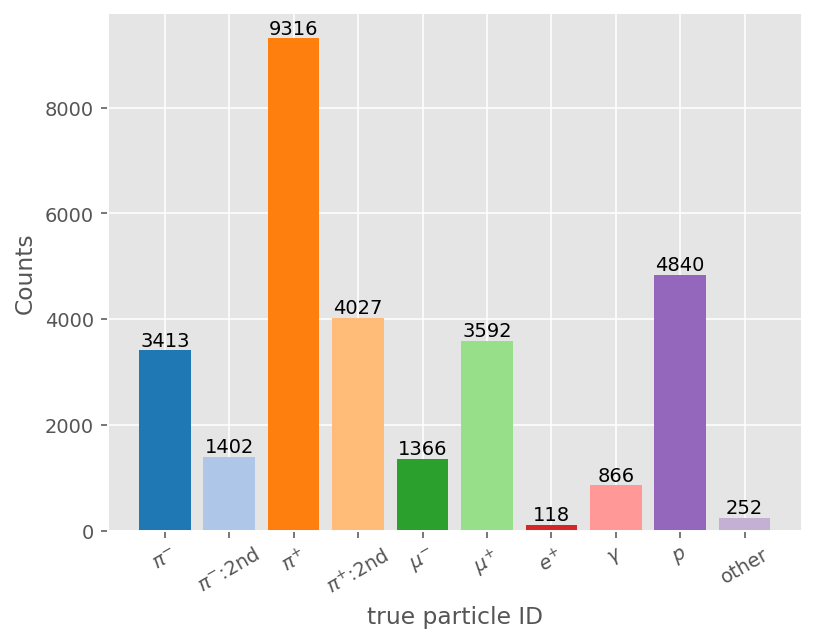

In [44]:
Plots.PlotTags(Tags.GenerateTrueParticleTagsPiPlus(samples["mc"]), "true particle ID")

# photon candidate selection

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos_SCE.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_endPos_SCE.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/

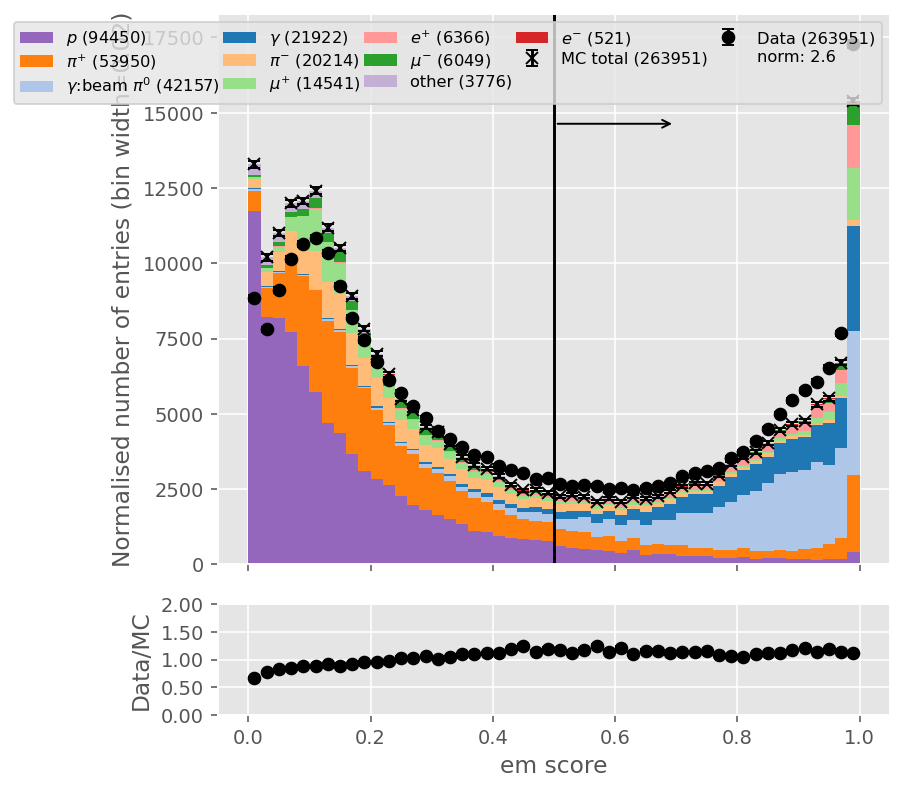

In [4]:
Plots.PlotTagged(samples["mc"].recoParticles.em_score, Tags.GenerateTrueParticleTagsPi0Shower(samples["mc"]), data2 = samples["data"].recoParticles.em_score, bins = 50, x_range = [0, 1], ncols = 5, x_label = "em score", norm = True)
Plots.DrawCutPosition(0.5)

masks = {s : PFOSelection.EMScoreCut(samples[s], 0.5) for s in samples}
FilterSamples(samples, masks, True)

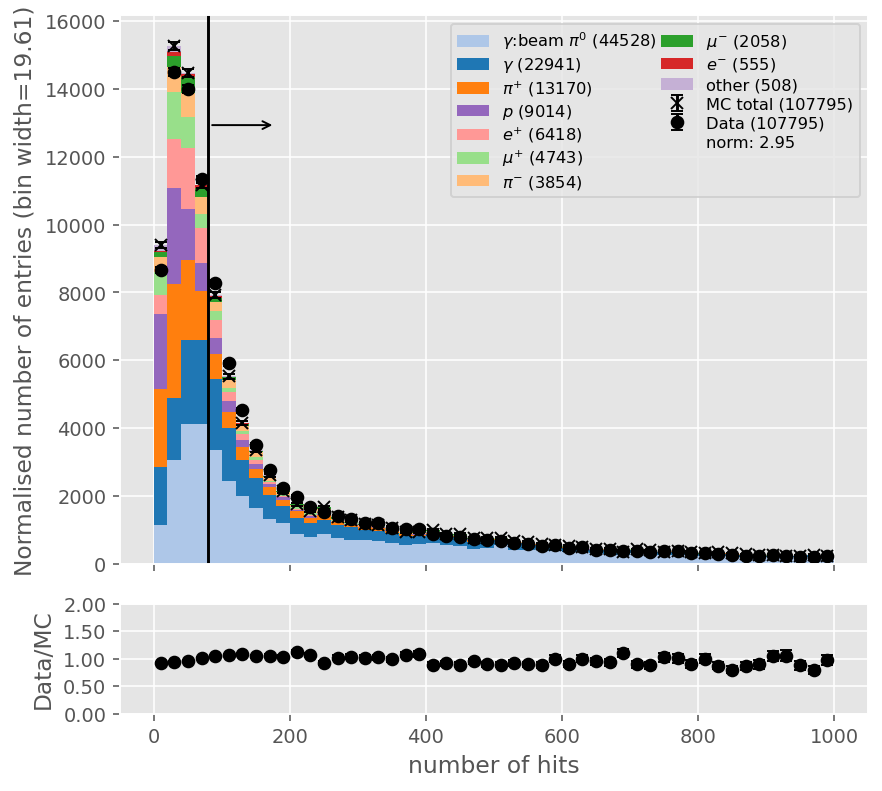

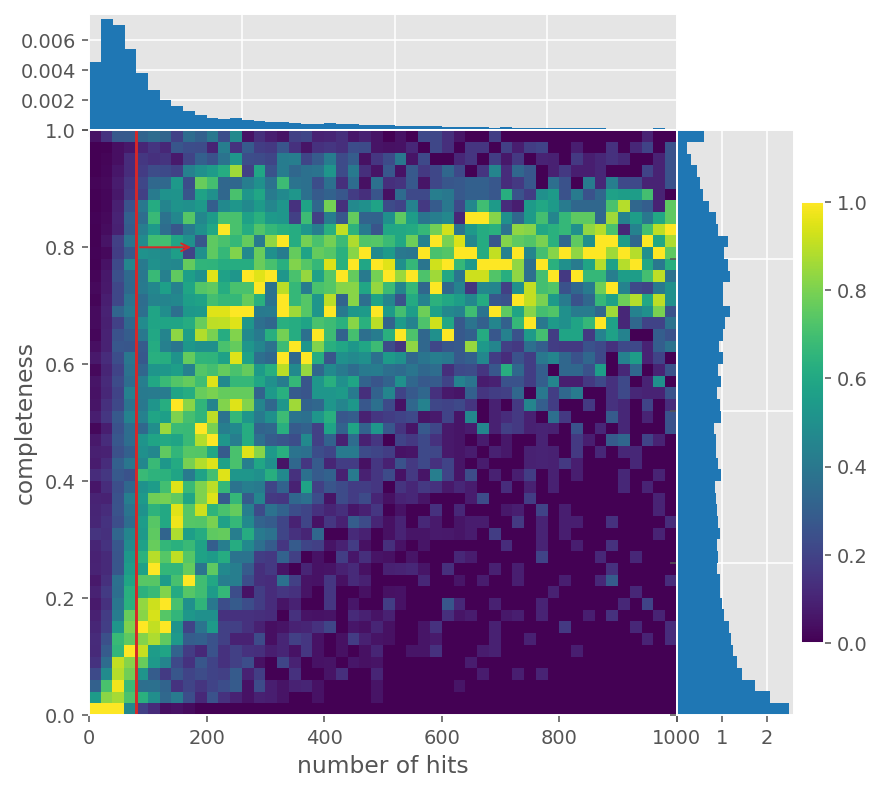

In [5]:
Plots.PlotTagged(samples["mc"].recoParticles.n_hits, Tags.GenerateTrueParticleTagsPi0Shower(samples["mc"]), data2 = samples["data"].recoParticles.n_hits, bins = 50, x_label = "number of hits", x_range = [0, 1000], norm = True)
Plots.DrawCutPosition(80, arrow_length = 100)

Plots.PlotHist2DImshowMarginal(ak.ravel(samples["mc"].recoParticles.n_hits), ak.ravel(samples["mc"].trueParticlesBT.completeness), bins = 50, y_range = [0, 1],x_range = [0, 1000], ylabel = "completeness", xlabel = "number of hits", norm = "column")
Plots.DrawCutPosition(80, flip = False, arrow_length = 100, color = "C6")

masks = {s : PFOSelection.NHitsCut(samples[s], 80) for s in samples}
FilterSamples(samples, masks, True)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_endPos.
  warnings.warn(f"Couldn't apply filters to {var}.")


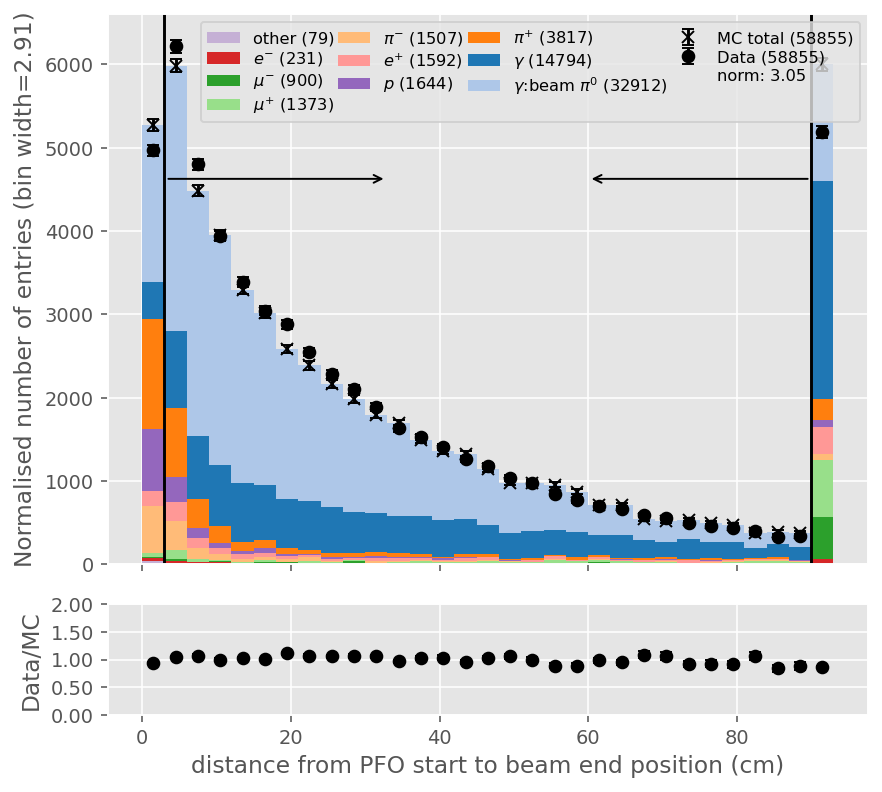

In [6]:
dist = {s : vector.dist(samples[s].recoParticles.shower_start_pos, samples[s].recoParticles.beam_endPos) for s in samples}

Plots.PlotTagged(dist["mc"], Tags.GenerateTrueParticleTagsPi0Shower(samples["mc"]), data2 = dist["data"], bins = 31, x_range = [0, 93], x_label = "distance from PFO start to beam end position (cm)", ncols = 4, norm = True, stacked = "ascending", truncate = True)
Plots.DrawCutPosition(3, arrow_length = 30, arrow_loc = 0.7)
Plots.DrawCutPosition(90, face = "left", arrow_length = 30, arrow_loc = 0.7)

masks = {s : PFOSelection.BeamParticleDistanceCut(samples[s], [3, 90]) for s in samples}
FilterSamples(samples, masks, True)

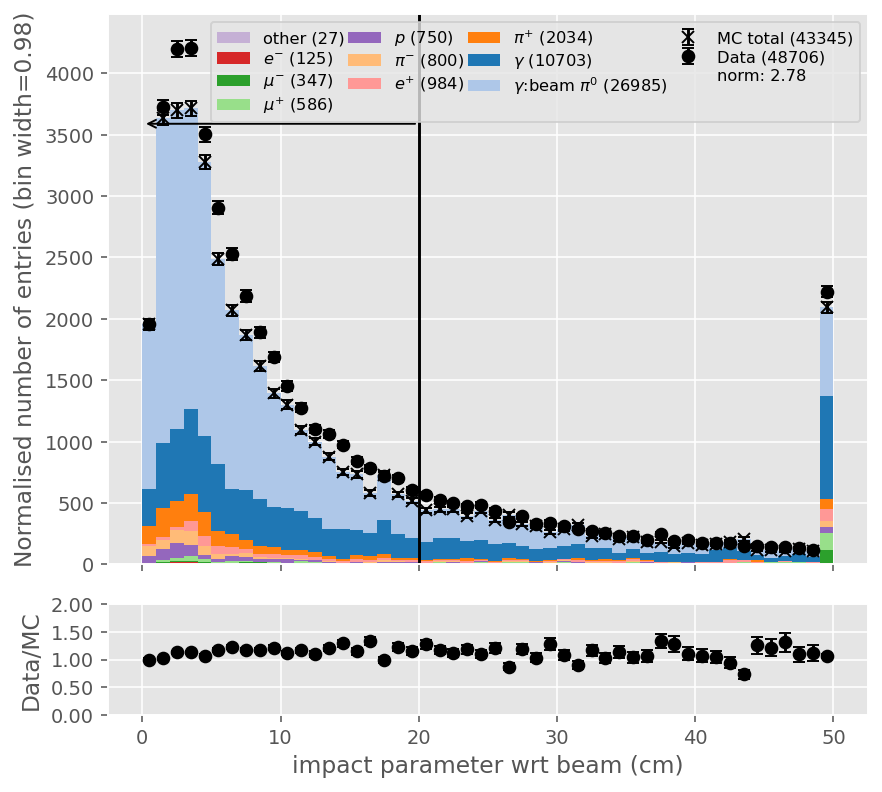

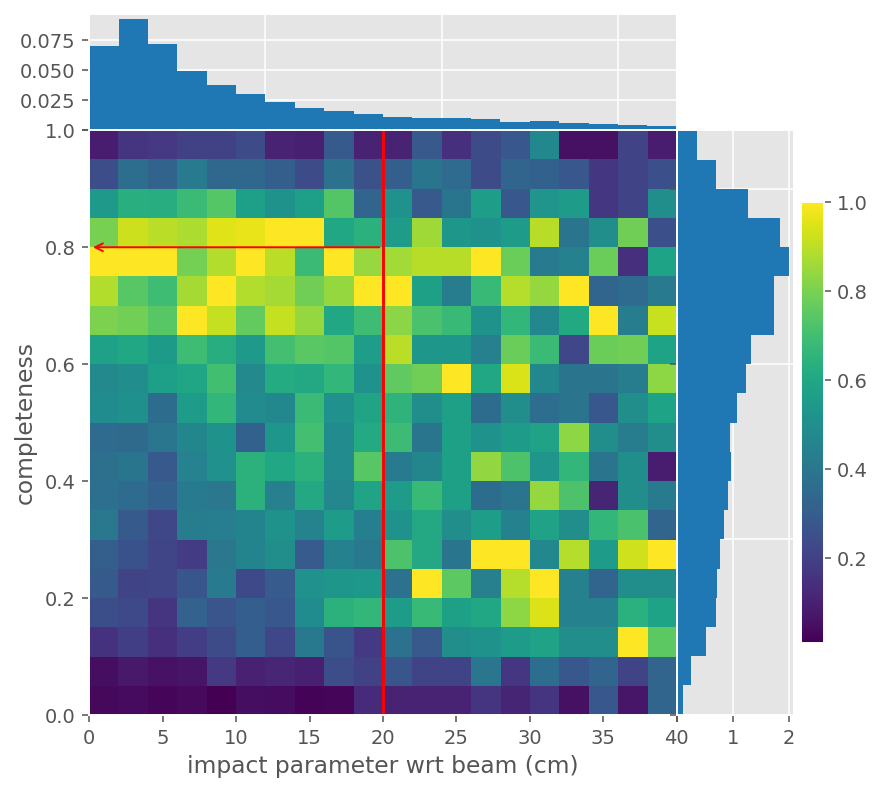

In [7]:
ip = {s : PFOSelection.find_beam_impact_parameters(samples[s]) for s in samples}

Plots.PlotTagged(ip["mc"], Tags.GenerateTrueParticleTagsPi0Shower(samples["mc"]), data2 = ip["data"], x_range = [0, 50], bins = 50, x_label = "impact parameter wrt beam (cm)", norm = args.norm, stacked = "ascending", ncols = 4, truncate = True)
Plots.DrawCutPosition(20, arrow_length = 20, face = "left")

Plots.PlotHist2DImshowMarginal(ak.ravel(ip["mc"]), ak.ravel(samples["mc"].trueParticlesBT.completeness), x_range = [0, 40], y_range = [0, 1], bins = 20, norm = "column", c_scale = "linear", ylabel = "completeness", xlabel = "impact parameter wrt beam (cm)")
Plots.DrawCutPosition(20, arrow_length = 20, face = "left", color = "red")

masks = {s : PFOSelection.BeamParticleIPCut(samples[s], 20) for s in samples}
FilterSamples(samples, masks, True)


(['$\\gamma$',
  '$\\gamma$:beam $\\pi^0$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$e^{-}$',
  '$p$',
  'other'],
 [2580, 8135, 93, 35, 621, 237, 226, 36, 218, 8])

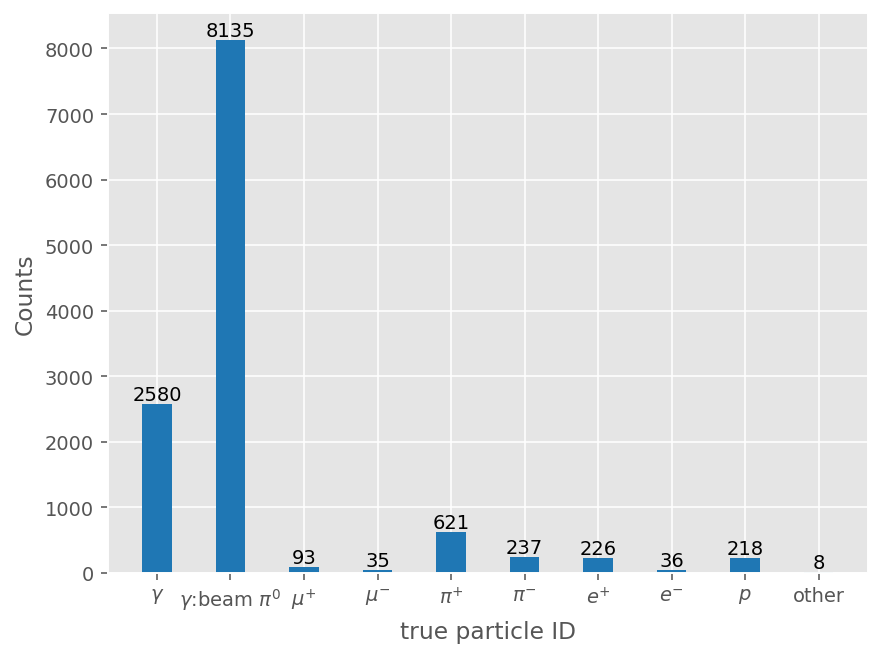

In [8]:
Plots.PlotTags(Tags.GenerateTrueParticleTagsPi0Shower(samples["mc"]), "true particle ID")

# $\pi^{0}$ selection

In [ ]:
samples["mc"].cutTable.get_table()
print(samples["mc"].cutTable.get_masks()[0])
print(samples["mc"].cutTable._signatures)
print(samples["mc"].cutTable._end_sig)

print(len(samples["mc"].cutTable.get_masks()[0][-1]))
print(ak.count(samples["mc"].cutTable.get_masks()[0][-1]))
print(ak.sum(samples["mc"].cutTable.get_masks()[0][-1]))

In [ ]:
# samples["mc"].cutTable._get_mask_signature(mask = samples["mc"].cutTable.get_masks()[0][-1], end = True)
mask = samples["mc"].cutTable.get_masks()[0][-1]
print(mask)
flat_array = isinstance(ak.count(mask, axis=0), int)
curr_simul_masks = samples["mc"].cutTable._group_masks(rcount=1)
mask = curr_simul_masks[0]
for m in curr_simul_masks[1:]:
    mask = mask[m]
if flat_array:
    end_sig = (ak.num(mask, axis=0), -1)
else:
    end_sig = (ak.num(mask, axis=0), ak.sum(mask))
print(end_sig)

print(curr_simul_masks)
# print(mask)
print(flat_array)

In [10]:
photonCandidates = {s : PFOSelection.InitialPi0PhotonSelection(samples[s]) for s in samples}

(['$\\gamma$',
  '$\\gamma$:beam $\\pi^0$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$e^{-}$',
  '$p$'],
 [838, 2891, 21, 3, 141, 34, 57, 11, 44])

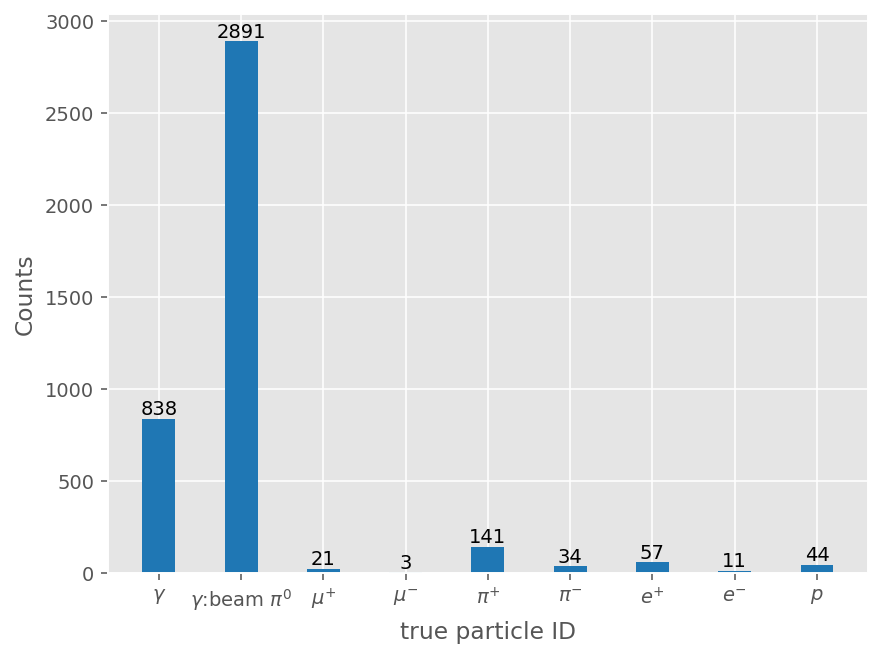

In [15]:
n_photons = {s : ak.sum(photonCandidates[s], -1) for s in samples}
tags = Tags.GenerateTrueParticleTagsPi0Shower(samples["mc"])
for t in tags:
    tags[t].mask = tags[t].mask & (n_photons["mc"] == 2)

Plots.PlotTags(tags, "true particle ID")

(['0 $\\gamma$',
  '1 $\\gamma$',
  "2 $\\gamma$'s, different $\\pi^{0}$",
  "2 $\\gamma$'s, same $\\pi^{0}$"],
 [2, 91, 220, 525])

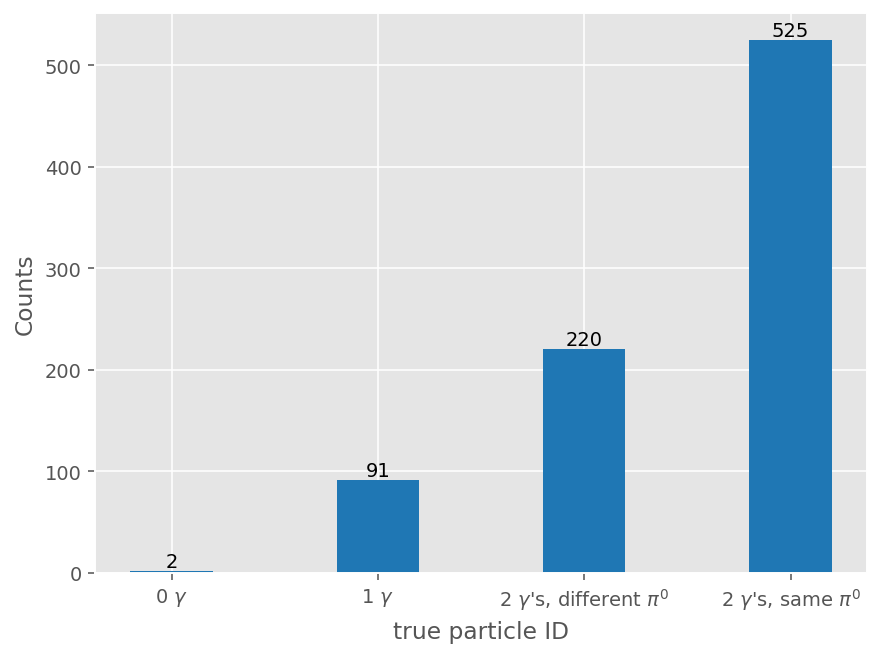

In [25]:
pi0_tags = Tags.GeneratePi0Tags(samples["mc"], photonCandidates["mc"])
for t in pi0_tags:
    pi0_tags[t].mask = pi0_tags[t].mask & (n_photons["mc"] == 2)
for t in pi0_tags:
    pi0_tags[t].mask = pi0_tags[t].mask & (tags["$\\gamma$"].mask)

bar_data = []
for tag in pi0_tags:
    bar_data.extend([tag]*ak.sum(pi0_tags[tag].mask))

Plots.PlotBar(bar_data, xlabel = "true particle ID")

30016

30016

2020

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


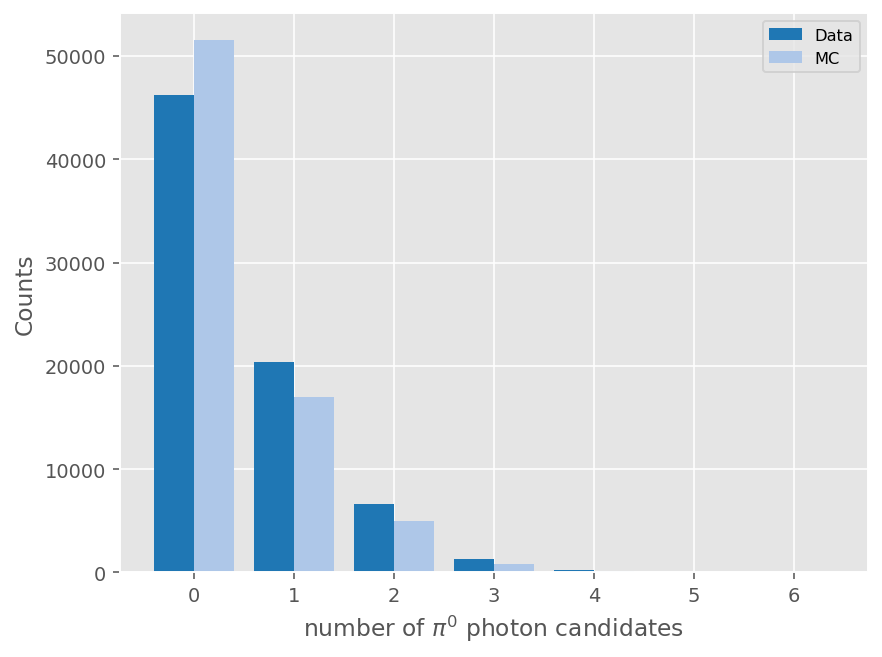

In [111]:
n_photons = {s : ak.sum(photonCandidates[s], -1) for s in samples}

scale = ak.count(n_photons["data"]) / ak.count(n_photons["mc"])

n_photons_scaled = []
u, c = np.unique(n_photons["mc"], return_counts = True)
for i, j in zip(u, c):
    n_photons_scaled.extend([i]* int(scale * j))

Plots.PlotBarComparision(n_photons_scaled, n_photons["data"], xlabel = "number of $\pi^{0}$ photon candidates", label_1 = "MC", label_2 = "Data", barlabel = False)

masks = {s : n_photons[s] == 2 for s in samples}

print(len(masks["mc"]))
print(ak.count(masks["mc"]))
print(ak.sum(masks["mc"]))


FilterSamples(samples, masks)
photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

no truth information found, sorting showers by reco energy instead

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(


{
    'mc': <Array [[116], [192], ... [627], [244]] type='2020 * var * float64'>,
    'data': <Array [[260], [127], ... [629], [242]] type='6592 * var * float64'>
}

some tags do not have colours, will override them for the default ones


2020

2020

1228

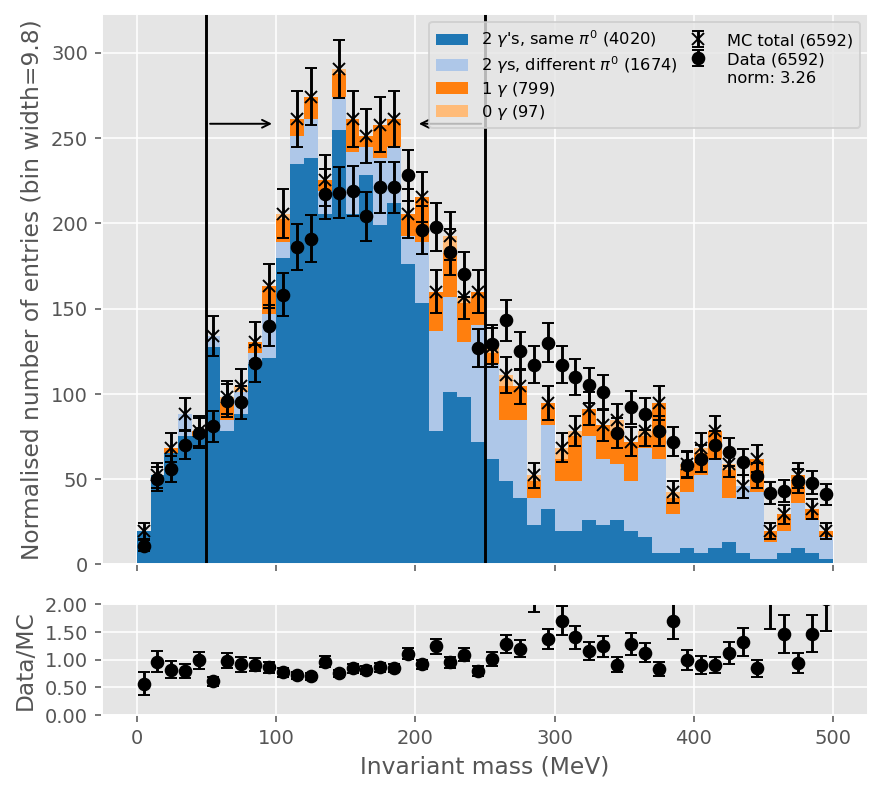

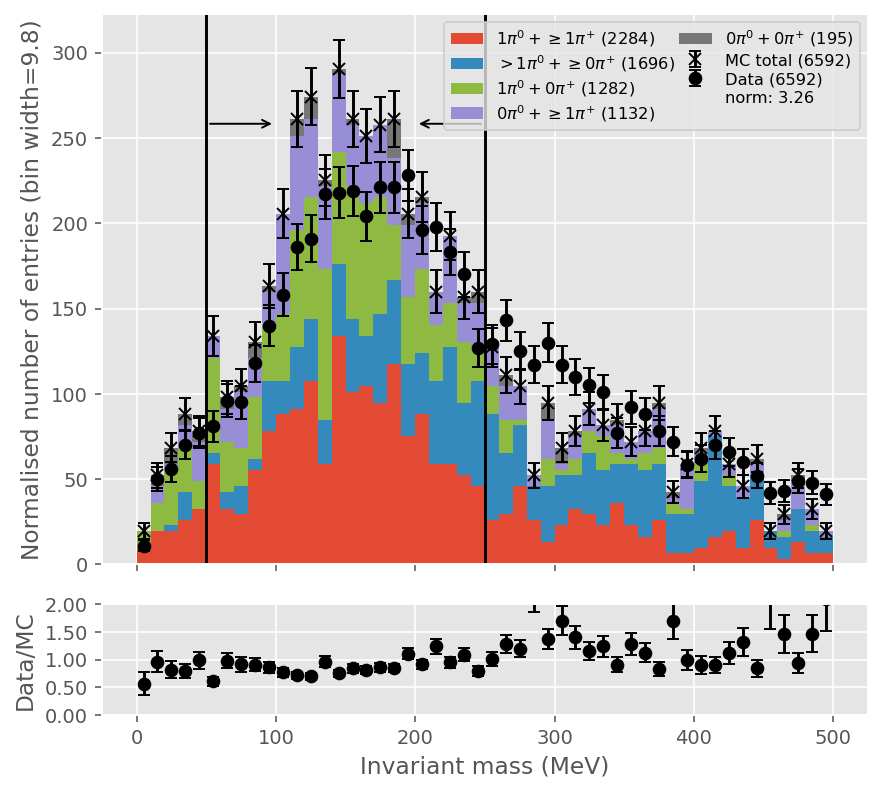

In [112]:
shower_pairs = {s : Master.ShowerPairs(samples[s], shower_pair_mask = photonCandidates[s]) for s in samples}

#* energy correction
correction_function = cross_section.EnergyCorrection.shower_energy_correction[args.correction]

with open(args.correction_params, "r") as f:
    correction_params = json.load(f)

e0 = {s : correction_function(shower_pairs[s].reco_lead_energy, **correction_params) for s in samples}
e1 = {s : correction_function(shower_pairs[s].reco_sub_energy, **correction_params) for s in samples}

mass = {s : Master.ShowerPairs.Mass(e0[s], e1[s], shower_pairs[s].reco_angle) for s in samples}
mass = {s : ak.fill_none(ak.pad_none(mass[s], 1, -1), -999, -1) for s in samples}
print(mass)

# mask = (mass > 50) & (mass < 250)
# mask = ak.flatten(mask) # 1 pi0


Plots.PlotTagged(mass["mc"], Tags.GeneratePi0Tags(samples["mc"], photonCandidates["mc"]), data2 = mass["data"], bins = 50, x_label = "Invariant mass (MeV)", x_range = [0, 500], norm = True)
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

Plots.PlotTagged(mass["mc"], EventSelection.GenerateTrueFinalStateTags(samples["mc"]), data2 = mass["data"], bins = 50, x_label = "Invariant mass (MeV)", x_range = [0, 500], norm = True)
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

masks = {s : ak.flatten((mass[s] > 50) & (mass[s] < 250)) for s in samples}

print(len(masks["mc"]))
print(ak.count(masks["mc"]))
print(ak.sum(masks["mc"]))

FilterSamples(samples, masks)
photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

In [ ]:
df = samples["mc"].cutTable.get_table()
print(df.iloc[-1])

no truth information found, sorting showers by reco energy instead

some tags do not have colours, will override them for the default ones


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1176: RuntimeWarning: divide by zero encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1176: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1177: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((data_err/h_data)**2 + (mc_error/h_mc)**2)


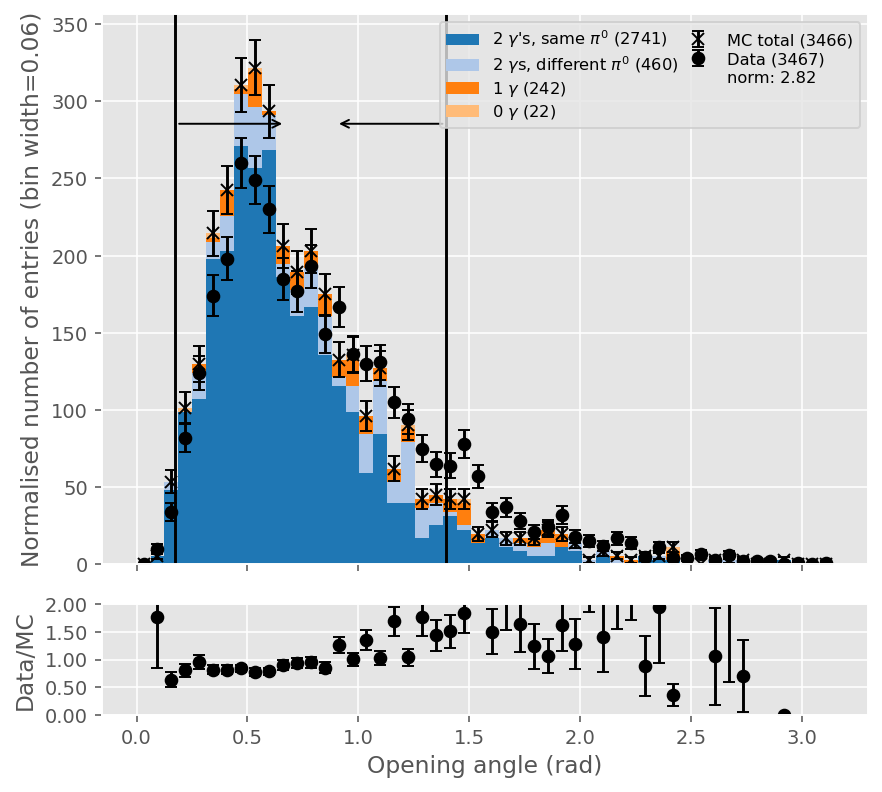

In [113]:
shower_pairs = {s : Master.ShowerPairs(samples[s], shower_pair_mask = photonCandidates[s]) for s in samples}

angle = {s : ak.flatten(shower_pairs[s].reco_angle) for s in samples}

Plots.PlotTagged(angle["mc"], Tags.GeneratePi0Tags(samples["mc"], photonCandidates["mc"]), data2 = angle["data"], bins = 50, x_label = "Opening angle (rad)", x_range = [0, np.pi], norm = True)
Plots.DrawCutPosition((10 * np.pi / 180), face = "right", arrow_length = 0.5)
Plots.DrawCutPosition((80 * np.pi / 180), face = "left", arrow_length = 0.5)

masks = {s : (angle[s] > (10 * np.pi / 180)) & (angle[s] < (80 * np.pi / 180)) for s in samples}
FilterSamples(samples, masks)
# photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

In [ ]:
samples["mc"].cutTable.get_table()

# samples["mc"].cutTable._data_changed = True
# for f in samples["mc"].cutTable:
#     print(f(samples["mc"].cutTable._init_data))

# samples["mc"].cutTable.get_masks()

In [ ]:
event_topology_tags = EventSelection.GenerateTrueFinalStateTags(samples["mc"])

for t in event_topology_tags:
    print(event_topology_tags[t].name_simple, ak.sum(event_topology_tags[t].mask), ak.count(event_topology_tags[t].mask))